C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

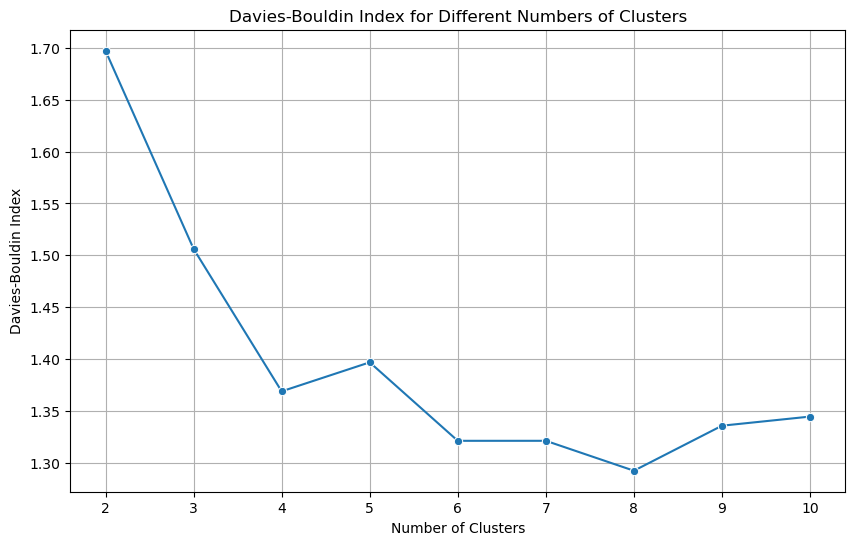

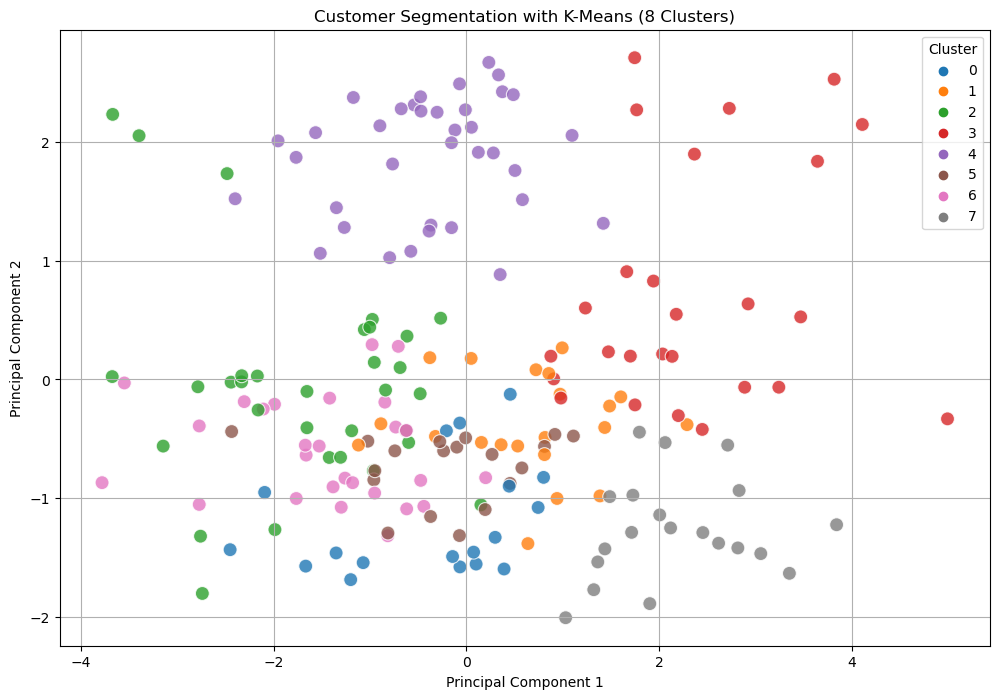

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
customers_df = pd.read_csv(r"Downloads/Customers.csv")  # Replace with the actual file path
transactions_df = pd.read_csv(r"Downloads/Transactions.csv")  # Replace with the actual file path

# Merge the datasets using CustomerID
merged_df = pd.merge(transactions_df, customers_df, on='CustomerID', how='inner')

# Feature Engineering
# Aggregate transaction metrics for each customer
customer_metrics = merged_df.groupby('CustomerID').agg(
    total_transactions=('TransactionID', 'count'),
    total_quantity=('Quantity', 'sum'),
    total_value=('TotalValue', 'sum'),
    avg_transaction_value=('TotalValue', 'mean')
).reset_index()

# Add profile data
profile_data = customers_df[['CustomerID', 'Region', 'SignupDate']]
customer_features = pd.merge(customer_metrics, profile_data, on='CustomerID', how='left')

# Extract the signup year from SignupDate
customer_features['SignupYear'] = pd.to_datetime(customer_features['SignupDate']).dt.year

# One-hot encode the 'Region' column
customer_features = pd.get_dummies(customer_features, columns=['Region'], drop_first=True)

# Drop unnecessary columns
customer_features = customer_features.drop(['CustomerID', 'SignupDate'], axis=1)

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features)

# Clustering and DB Index Calculation
db_indices = []
kmeans_models = {}

for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    kmeans_models[n_clusters] = (kmeans, cluster_labels)
    
    # Calculate the Davies-Bouldin Index
    db_index = davies_bouldin_score(scaled_features, cluster_labels)
    db_indices.append(db_index)

# Plot Davies-Bouldin Index for different cluster numbers
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(2, 11), y=db_indices, marker='o')
plt.title('Davies-Bouldin Index for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.xticks(range(2, 11))
plt.grid()
plt.show()

# Select the optimal number of clusters
optimal_clusters = db_indices.index(min(db_indices)) + 2
optimal_kmeans, optimal_labels = kmeans_models[optimal_clusters]

# Visualize clusters using PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

visualization_df = pd.DataFrame({
    'PCA1': pca_components[:, 0],
    'PCA2': pca_components[:, 1],
    'Cluster': optimal_labels
})

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=visualization_df, 
    x='PCA1', 
    y='PCA2', 
    hue='Cluster', 
    palette='tab10', 
    s=100, 
    alpha=0.8
)
plt.title(f'Customer Segmentation with K-Means ({optimal_clusters} Clusters)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid()
plt.show()


In [2]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load customer and transaction data
customers_df = pd.read_csv(r"Downloads/Customers.csv")
transactions_df = pd.read_csv(r"Downloads/Transactions.csv")

# Merge data for comprehensive customer profiles
customer_profile = pd.merge(customers_df, transactions_df, on='CustomerID', how='left')

# Feature engineering (example)
customer_profile['TotalValue'] = customer_profile.groupby('CustomerID')['Total'].transform('sum')
customer_profile['NumTransactions'] = customer_profile.groupby('CustomerID')['Quantity'].transform('sum')

# Select relevant features for clustering
features = ['Age', 'Annual Income (k$)', 'SpendingScore (1-100)', 'TotalValue', 'NumTransactions']
X = customer_profile[features].groupby('CustomerID').mean().reset_index()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[features])

# Determine optimal number of clusters using Elbow method and DB Index
inertia = []
db_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    db_scores.append(davies_bouldin_score(X_scaled, kmeans.labels_))

plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), inertia)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), db_scores)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('DB Index for Optimal k')
plt.show()

# Based on the Elbow method and DB Index, choose the optimal k (e.g., k=4)
optimal_k = 4  # Replace with the optimal k value

# Apply K-Means clustering with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
X['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize clusters (example with two features)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual Income (k$)', y='SpendingScore (1-100)', hue='Cluster', data=X, palette='viridis')
plt.title(f'Customer Segmentation (k={optimal_k})')
plt.show()

# Analyze cluster characteristics
cluster_profiles = X.groupby('Cluster')[features].mean()
print("Cluster Profiles:")
print(cluster_profiles)

KeyError: 'Column not found: Total'

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Davies-Bouldin Index: 0.752


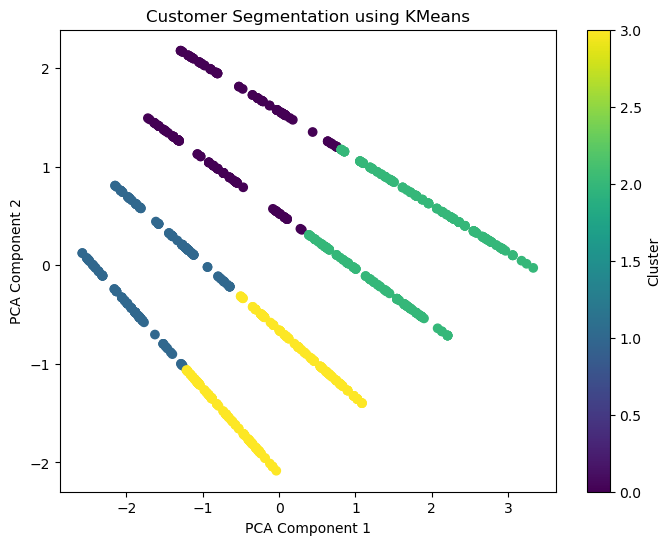

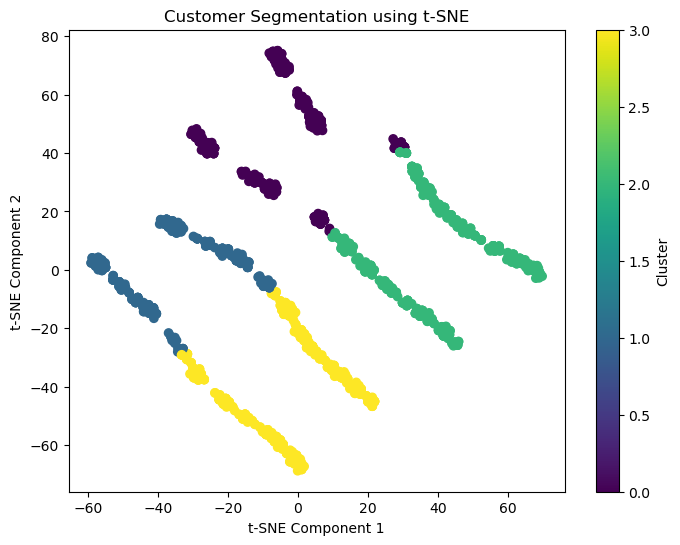

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Step 1: Load data
# Assuming 'Customers.csv' contains customer profile data (e.g., demographics, location)
# and 'Transactions.csv' contains transaction data (e.g., amount, frequency)

customers = pd.read_csv(r'Downloads/Customers.csv')
transactions = pd.read_csv(r'Downloads/Transactions.csv')

# Step 2: Data Preprocessing
# Merge the datasets based on 'CustomerID' (assuming both dataframes have this column)
data = pd.merge(customers, transactions, on='CustomerID')

# Step 3: Feature Selection
# Select relevant features from both profile and transaction data
# For simplicity, we assume 'Age', 'Income', 'TransactionAmount', 'TransactionFrequency' are the features
features = data[['Price', 'TotalValue', 'Quantity']]

# Step 4: Data Normalization (important for clustering)
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)

# Step 5: Clustering
# Choose the number of clusters (let's try KMeans with a range of 2 to 10 clusters)
kmeans = KMeans(n_clusters=4, random_state=42)  # You can adjust the number of clusters (between 2 and 10)
data['Cluster'] = kmeans.fit_predict(normalized_features)

# Step 6: Evaluation with Davies-Bouldin Index
db_index = davies_bouldin_score(normalized_features, data['Cluster'])
print(f'Davies-Bouldin Index: {db_index:.3f}')

# Step 7: Visualization
# Reduce the data to 2D using PCA or t-SNE for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(normalized_features)

# Create a scatter plot to visualize clusters
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=data['Cluster'], cmap='viridis')
plt.title('Customer Segmentation using KMeans')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Alternatively, use t-SNE for better visualization of high-dimensional data
tsne = TSNE(n_components=2, random_state=42)
tsne_data = tsne.fit_transform(normalized_features)

# Visualize using t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=data['Cluster'], cmap='viridis')
plt.title('Customer Segmentation using t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()
